# SLAF-based Privacy-Preserving CNN2 with Homomorphic Encryption

In [ ]:
!pip install tenseal
!pip install torch torchvision
!pip install matplotlib
!pip install torchsummary

In [ ]:
import torch
import tenseal as ts
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torch.nn.utils.fusion import fuse_conv_bn_eval
from time import time

# MNIST dataset

In [ ]:
torch.manual_seed(73)

train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

classes = train_loader.dataset.classes
onecycle=1

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

if torch.cuda.is_available():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
def sign(x):
  if x > 0:
    return 1
  elif x < 0:
    return -1
  else:
    return 0

x = np.linspace(-1,1,1000)
z = np.arange(-1, 1, .01)
y = np.sign(z)

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## CNN2

Training and testing will be carried out on the last model that is executed.

### CNN2-ReLU

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

onecycle=1
check = []
check2 = []
check_fn = []
check_fn2 = []

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 2, 1)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(20)
        self.pool = nn.AvgPool2d(3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 0)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc1 = nn.Linear(200, 100)
        self.batch2 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        #collect activation inputs
        if not self.training:
          check_fn.append(x.data)
        check.append(torch.max(torch.abs(x.data)))
        if torch.max(torch.abs(x.data)) > check[0]:
          check[0] = torch.max(torch.abs(x.data))
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batch2(x)
        if not self.training:
          check_fn2.append(x.data)
        check2.append(torch.max(torch.abs(x.data)))
        if torch.max(torch.abs(x.data)) > check2[0]:
          check2[0] = torch.max(torch.abs(x.data))
        x = F.relu(x)
        x = self.fc2(x)
        return x

net = Net()
print(net)

summary(net, (1, 28, 28))

### CNN2-SLAF

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

size_due_padding = 13
input_due_padding = 200
padding_conv1 = 1

class soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new)
                setattr(self, "alpha" + str(i) + ".requiresGrad", True) # set requiresGrad to true!

    def forward(self, x, size):
        ar_al = torch.zeros(self.alpha + 1, len(x), size, device = device)
        f = open('f1.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new)
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x):
        ar_al = torch.zeros(self.alpha + 1, len(x), 20, size_due_padding, size_due_padding, device=device)
        f = open('conv.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=100, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 2, padding_conv1)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(20)
        self.pool = nn.AvgPool2d(3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 0)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc1 = nn.Linear(input_due_padding, hidden)
        self.batch2 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(hidden, output)
        self.slu = soft_poly(hidden, alpha=3)
        self.cslu = conv_soft_poly(hidden, alpha=3)
        self.hidden_size = hidden

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.cslu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batch2(x)
        x = self.slu(x, 100)
        x = self.fc2(x)
        return x

net = ConvNet()

if torch.cuda.is_available():
  net.to(device)

print(net)

#### Collapsing linear layers

Since the combination of linear operations is linear and there is no intervening non-linearity between the first pooling layer and the first fully-connected layer of CNN2, the hidden layers between them can be collapsed into a single linear layer for the testing process.

Therefore, after each CNN2 model, several cells are incorporated to collapse linear layers, fuse convolutional and batch normalization layers, and generate a collapsed model for evaluation.

In [ ]:
_ = torch.manual_seed (2023)
# shape of intermediate "input" image
in_channels = 20
h = size_due_padding
w = h

#convolution parameters
out_channels = 50
kernel = 5
stride = 1

#fc paramaters
in_features=int (out_channels * (((h - kernel) / 2) + 1)**2)
in_features= input_due_padding
out_features = 100

#LAYERS DEFINITION
#conv2 = torch.nn.Conv2d (in_channels, out_channels, kernel, stride)
#fc1 = torch.nn.Linear (in_features, out_features)
pool1 = nn.AvgPool2d(3, stride=2, padding=1) ##!!!!!!!!!!!!

conv2 = net.conv2
fc1 = net.fc1
batch = net.batch2

# create collapsed bias from conv2 and fc1
bias = fc1 (torch.flatten (pool1(conv2 (pool1(torch.zeros (1, in_channels, h, w))))))
bias = ((torch.sub(bias, batch.running_mean))/torch.sqrt(torch.add(batch.running_var, batch.eps))) * batch.weight + batch.bias

# create collapsed weight from conv2 and fc1 (and bias)
# batch of images, each with only a single pixel turned on
n_pixels = in_channels * h * w   # number of pixels (including channels) in input image
pixel_batch = torch.eye (n_pixels).reshape (n_pixels, in_channels, h, w)
weight = (batch(fc1 (torch.flatten (pool1(conv2 (pool1(pixel_batch))), 1))) - bias).T

# create collapsed Linear
fcnew = torch.nn.Linear (n_pixels, out_features)   # Linear of correct shape

# copy in collapsed weight and bias
with torch.no_grad():
  _ = fcnew.weight.copy_ (weight)
  _ = fcnew.bias.copy_ (bias)

#### Fusing convolutional and batch normalization layer

In [ ]:
def fuse_all_conv_bn(model):
    stack = []
    for name, module in model.named_children():
        if list(module.named_children()):
            fuse_all_conv_bn(module)

        if isinstance(module, nn.BatchNorm2d):
            if isinstance(stack[-1][1], nn.Conv2d):
                setattr(model, stack[-1][0], fuse_conv_bn_eval(stack[-1][1], module))
                setattr(model, name, nn.Identity())
        else:
            stack.append((name, module))

net.eval()
fuse_all_conv_bn(net)

PATH = './mnist_net_collapsed.pth'
torch.save(net.state_dict(), PATH)

#### Collapsed SLAF

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new)
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x, size):
        ar_al = torch.zeros(self.alpha + 1, len(x), size, device = device)
        f = open('f1.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        # initialize alphai
        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new)
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x):
        ar_al = torch.zeros(self.alpha + 1, len(x), 20, size_due_padding, size_due_padding, device=device)
        f = open('conv.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=100, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 2, padding_conv1)
        self.fcnew = nn.Linear(3380, hidden)

        with torch.no_grad():
          _ = self.fcnew.weight.copy_ (weight)
          _ = self.fcnew.bias.copy_ (bias)

        self.fc2 = nn.Linear(hidden, output)
        self.slu = soft_poly(hidden, alpha=3)
        self.cslu = conv_soft_poly(hidden, alpha=3)
        self.hidden_size = hidden

    def forward(self, x):
        x = self.conv1(x)
        x = self.cslu(x)
        x = torch.flatten(x, 1)
        x = self.fcnew(x)
        x = self.slu(x, 100)
        x = self.fc2(x)
        return x

net_dos = ConvNet()

print(net_dos)

ConvNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (fcnew): Linear(in_features=3380, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (slu): soft_poly()
  (cslu): conv_soft_poly()
)


#### Weights control commands

In [ ]:
print(dict(net_dos.named_parameters()))

In [ ]:
print(net_dos.fcnew.weight.data[0][0])

In [ ]:
# Recover weights for collapsed model!
PATH = './mnist_net_collapsed.pth'
net_dos.load_state_dict(torch.load(PATH), strict=False)
net = net_dos

### CNN1-SLAF-R

1. Train CNN with ReLU (see above)
2. Re-train with SLAF-R; weights are fixed using requires_grad = False
3. Collapse retrained model
4. Test collapsed model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new)
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x, size):
        ar_al = torch.zeros(self.alpha + 1, len(x), size, device = device)
        f = open('f1.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        # initialize alphai
        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new)
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x):
        ar_al = torch.zeros(self.alpha + 1, len(x), 20, 13, 13, device=device)
        f = open('conv.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=100, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 2, 1)
        for param in self.conv1.parameters():
            param.data.requires_grad = False
        self.batch1 = nn.BatchNorm2d(20)
        for param in self.batch1.parameters():
            param.data.requires_grad = False
        self.pool = nn.AvgPool2d(3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 0)
        for param in self.conv2.parameters():
            param.data.requires_grad = False
        self.fc1 = nn.Linear(200, hidden)
        for param in self.fc1.parameters():
            param.data.requires_grad = False
        self.batch2 = nn.BatchNorm1d(100)
        for param in self.batch2.parameters():
            param.data.requires_grad = False
        self.fc2 = nn.Linear(hidden, output)
        for param in self.fc2.parameters():
            param.data.requires_grad = False
        self.slu = soft_poly(hidden, alpha=3)
        self.cslu = conv_soft_poly(hidden, alpha=3)
        self.hidden_size = hidden

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.cslu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batch2(x)
        x = self.slu(x, 100)
        x = self.fc2(x)
        return x

net_dos = ConvNet()

if torch.cuda.is_available():
  net_dos.to(device)
print(net_dos)

In [ ]:
print(dict(net.named_parameters()))

In [ ]:
PATH = './mnist_net.pth'
net_dos.load_state_dict(torch.load(PATH), strict=False)
net = net_dos

#### Collapsing linear layers

In [ ]:
_ = torch.manual_seed (2023)
# shape of intermediate "input" image
in_channels = 20
h = 13
w = h

#convolution parameters
out_channels = 50
kernel = 5
stride = 1

#fc paramaters
in_features=int (out_channels * (((h - kernel) / 2) + 1)**2)
in_features= 200
out_features = 100

#LAYERS DEFINITION
#conv2 = torch.nn.Conv2d (in_channels, out_channels, kernel, stride)
#fc1 = torch.nn.Linear (in_features, out_features)
pool1 = nn.AvgPool2d(3, stride=2, padding=1) ##!!!!!!!!!!!!

conv2 = net.conv2
fc1 = net.fc1
batch = net.batch2

# create collapsed bias from conv2 and fc1
bias = fc1 (torch.flatten (pool1(conv2 (pool1(torch.zeros (1, in_channels, h, w))))))
bias = ((torch.sub(bias, batch.running_mean))/torch.sqrt(torch.add(batch.running_var, batch.eps))) * batch.weight + batch.bias

# create collapsed weight from conv2 and fc1 (and bias)
# batch of images, each with only a single pixel turned on
n_pixels = in_channels * h * w   # number of pixels (including channels) in input image
pixel_batch = torch.eye (n_pixels).reshape (n_pixels, in_channels, h, w)
weight = (batch(fc1 (torch.flatten (pool1(conv2 (pool1(pixel_batch))), 1))) - bias).T

# create collapsed Linear
fcnew = torch.nn.Linear (n_pixels, out_features)   # Linear of correct shape

# copy in collapsed weight and bias
with torch.no_grad():
  _ = fcnew.weight.copy_ (weight)
  _ = fcnew.bias.copy_ (bias)

#### Fusing convolutional and batch normalization layer

In [ ]:
def fuse_all_conv_bn(model):
    stack = []
    for name, module in model.named_children():
        if list(module.named_children()):
            fuse_all_conv_bn(module)

        if isinstance(module, nn.BatchNorm2d):
            if isinstance(stack[-1][1], nn.Conv2d):
                setattr(model, stack[-1][0], fuse_conv_bn_eval(stack[-1][1], module))
                setattr(model, name, nn.Identity())
        else:
            stack.append((name, module))

net.eval()
fuse_all_conv_bn(net)

#Save the model for double training
PATH = './mnist_net_collapsed.pth'
torch.save(net.state_dict(), PATH)

#### Collapsed SLAF-R

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new)
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x, size):
        ar_al = torch.zeros(self.alpha + 1, len(x), size, device = device)
        f = open('f1.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        # initialize alphai
        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new) #
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x):
        ar_al = torch.zeros(self.alpha + 1, len(x), 20, 13, 13, device=device)
        f = open('conv.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=100, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 2, 1)
        self.fcnew = nn.Linear(3380, hidden)

        with torch.no_grad():
          _ = self.fcnew.weight.copy_ (weight)
          _ = self.fcnew.bias.copy_ (bias)

        self.fc2 = nn.Linear(hidden, output)
        self.slu = soft_poly(hidden, alpha=3)
        self.cslu = conv_soft_poly(hidden, alpha=3)
        self.hidden_size = hidden

    def forward(self, x):
        x = self.conv1(x)
        x = self.cslu(x)
        x = torch.flatten(x, 1)
        x = self.fcnew(x)
        x = self.slu(x, 100)
        x = self.fc2(x)
        return x

net_dos = ConvNet()

print(net_dos)

#### Weights control commands

In [ ]:
print(dict(net_dos.named_parameters()))

In [ ]:
PATH = './mnist_net_collapsed.pth'
net_dos.load_state_dict(torch.load(PATH), strict=False)
net = net_dos

### CNN2-SLAF-P

Polynomial Base

APPROXIMATING BY LEAST SQUARES ...
[-8.43752578e-04  2.81249562e-01  4.68762422e-06 -2.18749234e-03]
WRITING IN F1 y CONV FILES ...
           3             2
-0.002187 x + 4.688e-06 x + 0.2812 x - 0.0008438


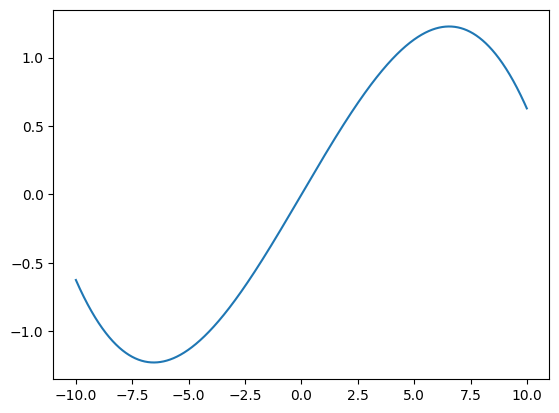

In [ ]:
GRADO = 3

def sign(x_my):
  if x_my > 0:
    return 1
  elif x_my < 0:
    return -1
  else:
    return 0

def comparison(enc_x):
    return enc_x.polyval([0.5, 0.197, 0, -0.004])

z_my = np.arange(-10, 10, 0.01)
y_my = np.sign(z_my)

LEAST_SQUARES = 0
COMPOSITION = 1
CHEBYSHEV = 2
NEWTHON = 3
FOURIER = 4

SELECTION = LEAST_SQUARES

if SELECTION == LEAST_SQUARES:
    print("APPROXIMATING BY LEAST SQUARES ....")
    polynomial = np.polyfit(z_my, y_my, GRADO)
    polynomial = polynomial[::-1]
    print(polynomial)
    print("WRITING IN F1 y CONV FILES ....")
    f = open('f1.txt', 'w')
    conv = open('conv.txt', 'w')
    for i in range(GRADO + 1):
        f.write('['+str(polynomial[i].tolist()) +']'+ '\n')
        conv.write('['+str(polynomial[i].tolist()) +']'+ '\n')
    f.close()
    conv.close()

elif SELECTION == CHEBYSHEV:
    print("APPROXIMATING BY CHEBYSHEV")
    if GRADO == 3:
        polynomial = [0, (7/3)*(1/10), 0, -(4/3)*(1/1000)]
    else:
        polynomial = [0, 1.2797, 0, -0.4444, 0, 0.2901 ,0, -0.2365, 0, 0.1111]
    print(polynomial)
    print("WRITING IN F1 y CONV FILES ....")
    f = open('f1.txt', 'w')
    conv = open('conv.txt', 'w')
    for i in range(GRADO + 1):
        f.write('['+str(polynomial[i]) +']'+ '\n')
        conv.write('['+str(polynomial[i]) +']'+ '\n')
    f.close()
    conv.close()

elif SELECTION == COMPOSITION:
    print("APPROXIMATING BY COMPOSITION ....")
    if GRADO == 3:
        polynomial = [0, (2126/1024)*(1/10), 0, (-1359/1024)*(1/1000)]
    else:
        f = np.poly1d([(-1/2), 0, (3/2),0])
        g = np.poly1d([(-1359/1024), 0, (2126/1024),0])
        polynomial = f(g)
    print(polynomial)
    print("WRITING IN F1 y CONV FILES ....")
    f = open('f1.txt', 'w')
    conv = open('conv.txt', 'w')
    for i in range(GRADO + 1):
        f.write('['+str(polynomial[i]) +']'+ '\n')
        conv.write('['+str(polynomial[i]) +']'+ '\n')
    f.close()
    conv.close()

elif SELECTION == NEWTHON:
    print("APPROXIMATING BY NEWTON ....")
    polynomial = [0, (3/2)*(1/10), 0, (-1/2)*(1/1000)]
    print(polynomial)
    print("WRITING IN F1 y CONV FILES ....")
    f = open('f1.txt', 'w')
    conv = open('conv.txt', 'w')
    for i in range(GRADO + 1):
        f.write('['+str(polynomial[i]) +']'+ '\n')
        conv.write('['+str(polynomial[i]) +']'+ '\n')
    f.close()
    conv.close()

## GRAPH THE POLYNOMIAL
f = open('conv.txt', 'r')
list_take=[]

for i in range(GRADO + 1):
    take = float(f.readline().replace('[','').replace(']',''))
    list_take.append(take)
f.close()

list_take.reverse()
poly_ = np.poly1d(list_take)
print(poly_)

fig = plt.figure()
ax = fig.add_subplot(111)
poly_ff = [np.polyval(poly_, i) for i in z_my]

ax.plot(z_my, poly_ff)

CNN2 model using SLAF-P

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

size_due_padding = 13
input_due_padding = 200
padding_conv1 = 1

class soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            f = open('f1.txt', 'r')
            for i in range(alpha + 1):
                next_value = float(f.readline().replace('[','').replace(']',''))
                setattr(self, "alpha" + str(i), torch.tensor(next_value, device = device))
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)
            f.close()

    def forward(self, x, size):
        ar_al = torch.zeros(self.alpha + 1, len(x), size, device = device)
        f = open('f1.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            f = open('conv.txt', 'r')
            for i in range(alpha + 1):
                next_value = float(f.readline().replace('[','').replace(']',''))
                setattr(self, "alpha" + str(i), torch.tensor(next_value, device = device))
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)
            f.close()

    def forward(self, x):
        ar_al = torch.zeros(self.alpha + 1, len(x), 20, size_due_padding, size_due_padding, device=device)
        f = open('conv.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=100, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 2, padding_conv1)
        for param in self.conv1.parameters():
            param.data.requires_grad = False
        self.batch1 = nn.BatchNorm2d(20)
        for param in self.batch1.parameters():
            param.data.requires_grad = False
        self.pool = nn.AvgPool2d(3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 0)
        for param in self.conv2.parameters():
            param.data.requires_grad = False
        self.fc1 = nn.Linear(input_due_padding, hidden)
        for param in self.fc1.parameters():
            param.data.requires_grad = False
        self.batch2 = nn.BatchNorm1d(100)
        for param in self.batch2.parameters():
            param.data.requires_grad = False
        self.fc2 = nn.Linear(hidden, output)
        for param in self.fc2.parameters():
            param.data.requires_grad = False
        self.slu = soft_poly(hidden, alpha=3)
        self.cslu = conv_soft_poly(hidden, alpha=3)
        self.hidden_size = hidden

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        #ReLU using sign function approximations
        x = (x + x*self.cslu(x))/2
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batch2(x)
        x = (x + x*self.slu(x, 100))/2
        x = self.fc2(x)
        return x

net_dos = ConvNet()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
print(net_dos.state_dict())

In [ ]:
PATH = './mnist_net_.pth'
net_dos.load_state_dict(torch.load(PATH), strict=False)
net = net_dos
#OPTIONAL: net = nn.DataParallel(net)

#### Collapsing linear layers

In [ ]:
_ = torch.manual_seed (2023)
# shape of intermediate "input" image
in_channels = 20
h = size_due_padding
w = h

#convolution parameters
out_channels = 50
kernel = 5
stride = 1

#fc paramaters
in_features=int (out_channels * (((h - kernel) / 2) + 1)**2)
in_features= input_due_padding
out_features = 100

#LAYERS DEFINITION
#conv2 = torch.nn.Conv2d (in_channels, out_channels, kernel, stride)
#fc1 = torch.nn.Linear (in_features, out_features)
pool1 = nn.AvgPool2d(3, stride=2, padding=1) ##!!!!!!!!!!!!

conv2 = net.conv2
fc1 = net.fc1
batch = net.batch2

# create collapsed bias from conv2 and fc1
bias = fc1 (torch.flatten (pool1(conv2 (pool1(torch.zeros (1, in_channels, h, w))))))
bias = ((torch.sub(bias, batch.running_mean))/torch.sqrt(torch.add(batch.running_var, batch.eps))) * batch.weight + batch.bias

# create collapsed weight from conv2 and fc1 (and bias)
# batch of images, each with only a single pixel turned on
n_pixels = in_channels * h * w   # number of pixels (including channels) in input image
pixel_batch = torch.eye (n_pixels).reshape (n_pixels, in_channels, h, w)
weight = (batch(fc1 (torch.flatten (pool1(conv2 (pool1(pixel_batch))), 1))) - bias).T

# create collapsed Linear
fcnew = torch.nn.Linear (n_pixels, out_features)   # Linear of correct shape

# copy in collapsed weight and bias
with torch.no_grad():
  _ = fcnew.weight.copy_ (weight)
  _ = fcnew.bias.copy_ (bias)

#### Fusing convolutional and batch normalization layer

In [ ]:
def fuse_all_conv_bn(model):
    stack = []
    for name, module in model.named_children():
        if list(module.named_children()):
            fuse_all_conv_bn(module)

        if isinstance(module, nn.BatchNorm2d):
            if isinstance(stack[-1][1], nn.Conv2d):
                setattr(model, stack[-1][0], fuse_conv_bn_eval(stack[-1][1], module))
                setattr(model, name, nn.Identity())
        else:
            stack.append((name, module))

net.eval()
fuse_all_conv_bn(net)

PATH = './mnist_net_collapsed.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
print(net.state_dict())

#### Collapsed SLAF-P

In [ ]:
class soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device)) # create a tensor out of alpha
        else:
            f = open('f1.txt', 'r')
            for i in range(alpha + 1):
                next_value = float(f.readline())
                setattr(self, "alpha" + str(i), torch.tensor(next_value, device = device))
                setattr(self, "alpha" + str(i) + ".requiresGrad", True) # set requiresGrad to true!
            f.close()

    def forward(self, x, size):
        ar_al = torch.zeros(self.alpha + 1, len(x), size, device = device)
        f = open('f1.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)  # create a tensor out of alpha
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            f = open('conv.txt', 'r')
            for i in range(alpha + 1):
                next_value = float(f.readline())
                setattr(self, "alpha" + str(i), torch.tensor(next_value, device = device))
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)
            f.close()

    def forward(self, x):
        ar_al = torch.zeros(self.alpha + 1, len(x), 20, size_due_padding, size_due_padding, device=device)
        f = open('conv.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)  # create a tensor out of alpha
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=100, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 2, padding_conv1)
        self.fcnew = nn.Linear(3380, hidden) #2880

        with torch.no_grad():
          _ = self.fcnew.weight.copy_ (weight)
          _ = self.fcnew.bias.copy_ (bias)

        self.fc2 = nn.Linear(hidden, output)
        self.slu = soft_poly(hidden, alpha=3)
        self.cslu = conv_soft_poly(hidden, alpha=3)
        self.hidden_size = hidden

    def forward(self, x):
        x = self.conv1(x)
        x = (x + x*self.cslu(x))/2
        x = torch.flatten(x, 1)
        x = self.fcnew(x)
        x = (x + x*self.slu(x, 100))/2
        x = self.fc2(x)
        return x

net_dos = ConvNet()

print(net_dos)

ConvNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (fcnew): Linear(in_features=3380, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (slu): soft_poly()
  (cslu): conv_soft_poly()
)


#### Weights control commands

In [ ]:
print(dict(net.named_parameters()))

In [ ]:
print(net_dos.fcnew.weight.data[0][0])

In [ ]:
PATH = './mnist_net_collapsed.pth'
net_dos.load_state_dict(torch.load(PATH), strict=False)
net = net_dos

In [ ]:
PATH = './mnist_net_.pth'
net_dos.load_state_dict(torch.load(PATH), strict=False)
net = net_dos

### CNN2-ReLU (without padding)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

onecycle=1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 2, 0)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(20)
        self.pool = nn.AvgPool2d(3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 0)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc1 = nn.Linear(50, 100)
        self.batch2 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batch2(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

net = Net()
print(net)

summary(net, (1, 28, 28))

### CNN2-SLAF-R (without padding)

1. Train CNN with ReLU (above)
2. Re-train with SLAF-R; weights are fixed using requires_grad = False
3. Collapse retrained model
4. Test collapsed model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new)
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x, size):
        ar_al = torch.zeros(self.alpha + 1, len(x), size, device = device)
        f = open('f1.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        # initialize alphai
        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new)
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x):
        ar_al = torch.zeros(self.alpha + 1, len(x), 20, 12, 12, device=device)
        f = open('conv.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=100, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 2, 0)
        for param in self.conv1.parameters():
            param.data.requires_grad = False
        self.batch1 = nn.BatchNorm2d(20)
        for param in self.batch1.parameters():
            param.data.requires_grad = False
        self.pool = nn.AvgPool2d(3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 0)
        for param in self.conv2.parameters():
            param.data.requires_grad = False
        self.fc1 = nn.Linear(50, hidden)
        for param in self.fc1.parameters():
            param.data.requires_grad = False
        self.batch2 = nn.BatchNorm1d(100)
        for param in self.batch2.parameters():
            param.data.requires_grad = False
        self.fc2 = nn.Linear(hidden, output)
        for param in self.fc2.parameters():
            param.data.requires_grad = False
        self.slu = soft_poly(hidden, alpha=3)
        self.cslu = conv_soft_poly(hidden, alpha=3)
        self.hidden_size = hidden

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.cslu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batch2(x)
        x = self.slu(x, 100)
        x = self.fc2(x)
        return x

net_dos = ConvNet()

if torch.cuda.is_available():
  net_dos.to(device)
print(net_dos)

In [ ]:
print(dict(net.named_parameters()))

In [ ]:
PATH = './mnist_net.pth'
net_dos.load_state_dict(torch.load(PATH), strict=False)
net = net_dos

#### Collapsing linear layers

In [ ]:
_ = torch.manual_seed (2023)
# shape of intermediate "input" image
in_channels = 20
h = 12
w = h

#convolution parameters
out_channels = 50
kernel = 5
stride = 1

#fc paramaters
in_features=int (out_channels * (((h - kernel) / 2) + 1)**2)
in_features= 50
out_features = 100

#LAYERS DEFINITION
#conv2 = torch.nn.Conv2d (in_channels, out_channels, kernel, stride)
#fc1 = torch.nn.Linear (in_features, out_features)
pool1 = nn.AvgPool2d(3, stride=2, padding=1)

conv2 = net.conv2
fc1 = net.fc1
batch = net.batch2

# create collapsed bias from conv2 and fc1
bias = fc1 (torch.flatten (pool1(conv2 (pool1(torch.zeros (1, in_channels, h, w))))))
bias = ((torch.sub(bias, batch.running_mean))/torch.sqrt(torch.add(batch.running_var, batch.eps))) * batch.weight + batch.bias

# create collapsed weight from conv2 and fc1 (and bias)
# batch of images, each with only a single pixel turned on
n_pixels = in_channels * h * w   # number of pixels (including channels) in input image
pixel_batch = torch.eye (n_pixels).reshape (n_pixels, in_channels, h, w)
weight = (batch(fc1 (torch.flatten (pool1(conv2 (pool1(pixel_batch))), 1))) - bias).T

# create collapsed Linear
fcnew = torch.nn.Linear (n_pixels, out_features)   # Linear of correct shape

# copy in collapsed weight and bias
with torch.no_grad():
  _ = fcnew.weight.copy_ (weight)
  _ = fcnew.bias.copy_ (bias)

#### Fusing convolutional and batch normalization layer

In [ ]:
def fuse_all_conv_bn(model):
    stack = []
    for name, module in model.named_children():
        if list(module.named_children()):
            fuse_all_conv_bn(module)

        if isinstance(module, nn.BatchNorm2d):
            if isinstance(stack[-1][1], nn.Conv2d):
                setattr(model, stack[-1][0], fuse_conv_bn_eval(stack[-1][1], module))
                setattr(model, name, nn.Identity())
        else:
            stack.append((name, module))

net.eval()
fuse_all_conv_bn(net)

#Save the model for double training
PATH = './mnist_net_collapsed.pth'
torch.save(net.state_dict(), PATH)

#### Collapsed SLAF-R (without padding)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device)) # create a tensor out of alpha
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new) # create a tensor out of alpha
                setattr(self, "alpha" + str(i) + ".requiresGrad", True) # set requiresGrad to true!


    def forward(self, x, size):
        ar_al = torch.zeros(self.alpha + 1, len(x), size, device = device)
        f = open('f1.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

        # initialize alphai
        if alpha == None:
            self.alpha = nn.Parameter(torch.tensor(1000,64, device = device))
        else:
            for i in range(alpha + 1):
                tensor_new = torch.nn.Parameter(torch.zeros(1, device = device))
                setattr(self, "alpha" + str(i), tensor_new)
                setattr(self, "alpha" + str(i) + ".requiresGrad", True)

    def forward(self, x):
        ar_al = torch.zeros(self.alpha + 1, len(x), 20, 12, 12, device=device)
        f = open('conv.txt', 'w')
        for i in range(self.alpha + 1):
            temp = getattr(self, "alpha" + str(i))
            ar_al[i] = temp * (x**i)
            f.write(str(temp.data.tolist()) + '\n')
        f.close()
        return torch.sum(ar_al, dim=0)

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=100, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 2, 0)
        self.fcnew = nn.Linear(2880, hidden)

        with torch.no_grad():
          _ = self.fcnew.weight.copy_ (weight)
          _ = self.fcnew.bias.copy_ (bias)

        self.fc2 = nn.Linear(hidden, output)
        self.slu = soft_poly(hidden, alpha=3)
        self.cslu = conv_soft_poly(hidden, alpha=3)
        self.hidden_size = hidden

    def forward(self, x):
        x = self.conv1(x)
        x = self.cslu(x)
        x = torch.flatten(x, 1)
        x = self.fcnew(x)
        x = self.slu(x, 100)
        x = self.fc2(x)
        return x

net_dos = ConvNet()

print(net_dos)

ConvNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(2, 2))
  (fcnew): Linear(in_features=2880, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (slu): soft_poly()
  (cslu): conv_soft_poly()
)


#### Weights control commands

In [ ]:
print(dict(net_dos.named_parameters()))

In [ ]:
print(net_dos.fcnew.weight.data[0][0])

In [ ]:
PATH = './mnist_net_collapsed.pth'
net_dos.load_state_dict(torch.load(PATH), strict=False)
net = net_dos

### CryptoNets

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 2, 1)
        self.pool1 = nn.AvgPool2d(3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(20, 50, 5, (2, 2), 0)
        self.fc1 = nn.Linear(1250, 100)
        self.fc2 = nn.Linear(100, 10)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)

    def forward(self, x):
        x = self.conv1(x)
        #Use x = x * x for CNN-HE
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

net = Net()
print(net)

summary(net, (1, 28, 28))

#### Collapsing linear layers

In [ ]:
_ = torch.manual_seed (2023)
# shape of intermediate "input" image
in_channels = 20
h = 13
w = h

#convolution parameters
out_channels = 50
kernel = 5
stride = 2

#fc paramaters
in_features=int (out_channels * (((h - kernel) / 2) + 1)**2)
out_features = 100

#LAYERS DEFINITION
#conv2 = torch.nn.Conv2d (in_channels, out_channels, kernel, stride)
#fc1 = torch.nn.Linear (in_features, out_features)
pool1 = nn.AvgPool2d(3, stride=1, padding=1) ##!!!!!!!!!!!!

conv2 = net.conv2
fc1 = net.fc1

# create collapsed bias from conv2 and fc1
bias = fc1 (torch.flatten (pool1(conv2 (pool1(torch.zeros (1, in_channels, h, w))))))

# create collapsed weight from conv2 and fc1 (and bias)
# batch of images, each with only a single pixel turned on
n_pixels = in_channels * h * w   # number of pixels (including channels) in input image
pixel_batch = torch.eye (n_pixels).reshape (n_pixels, in_channels, h, w)
weight = (fc1 (torch.flatten (pool1(conv2 (pool1(pixel_batch))), 1)) - bias).T

# create collapsed Linear
fcnew = torch.nn.Linear (n_pixels, out_features)   # Linear of correct shape

# copy in collapsed weight and bias
with torch.no_grad():
  _ = fcnew.weight.copy_ (weight)
  _ = fcnew.bias.copy_ (bias)

# check on example batch of images
input = torch.randn (5, in_channels, h, w)
out_two_layer = fc1 (torch.flatten (conv2 (input), 1))
out_collapsed = fcnew (torch.flatten (input, 1))

torch.allclose (out_collapsed, out_two_layer, atol = 1.e-5)

global_weight = weight
global_bias = bias

#### Collapsed CryptoNets

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 2, 1)
        self.pool1 = nn.AvgPool2d(3, stride=1, padding=1)
        self.fcnew = nn.Linear(3380, 100)
        self.fc2 = nn.Linear(100, 10)

        with torch.no_grad():
          _ = self.fcnew.weight.copy_ (weight)
          _ = self.fcnew.bias.copy_ (bias)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fcnew(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

net2 = Net()
print(net2)
summary(net2, (1, 28, 28))

#### Weights control commands

In [ ]:
print(net2.fcnew.weight.data[0][0])

tensor(0.0050)


In [ ]:
net.load_state_dict(torch.load('./mnist_net.pth'), strict=False)

<All keys matched successfully>

In [ ]:
net2.load_state_dict(torch.load('./mnist_net.pth'), strict=False)
net = net2

## One-Cycle

In [ ]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()

        avg_loss = loss/(1 - beta**i)

        acc_ = ((torch.argmax(scores, dim=1) == y).sum()/scores.size(0))
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())

        losses.append(avg_loss)
        log_lrs.append(lr)

        cost.backward()
        optimiser.step()

        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr

    return log_lrs, losses, accuracies

## Training

In [ ]:
#ADAM
import torch.optim as optim
onecycle = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
#SGD with One-cycle
import torch.optim as optim
onecycle =1
criterion = nn.CrossEntropyLoss()
if onecycle==1:
  optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.95, weight_decay=1e-4)
  print("With One-Cycle")
else:
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
  print("Without One-Cycle")

With One-Cycle


In [ ]:
lg_lr, losses, accuracies = find_lr(net, optimizer, start_val=1e-6, end_val=10)

In [ ]:
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
ax1.set_xticks([1e-1, 2e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

In [ ]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                max_lr=2e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs = 30, pct_start=0.43,
                                                div_factor=10,
                                                final_div_factor=1000,
                                                three_phase=True, verbose=False
                                            )

In [ ]:
print(len(train_loader))

938


In [ ]:
def train(model, train_loader, criterion, optimizer, n_epochs=30):
    model.train()

    if onecycle == 1:
      print("With One-Cycle")
    else:
      print("Without One-Cycle")

    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        correct_new = 0
        total_new = 0
        for data, target in train_loader:
            if torch.cuda.is_available():
              data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_new += target.size(0)
            correct_new += (predicted == target).sum().item()

            #One-cycle
            if onecycle == 1:
              scheduler.step()

        # calculate average losses
        train_loss = train_loss / len(train_loader)
        acc_new = 100 * correct_new / total_new

        print('Epoch: {} \tTraining Loss: {:.6f} \tCorrect: {} \tAccuracy: {:.3f}'.format(epoch, train_loss, correct_new, acc_new))

    print('Finished Training')

    return model

In [ ]:
net = train(net, train_loader, criterion, optimizer)

In [ ]:
#Save the model for re-training
PATH = './mnist_net_.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
print(check[0])
print(check2[0])

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

## Plaintext testing

In [ ]:
def test(model, test_loader, criterion):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()
    j = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader)
    print(f'Test Loss: {test_loss:.6f}\n')


    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )

In [ ]:
t_start = time()
test(net, test_loader, criterion)
t_end = time()
t_total = (t_end - t_start)*1000
print(t_total)

Test Loss: 0.021133

Test Accuracy of 0: 99% (978/980)
Test Accuracy of 1: 99% (1130/1135)
Test Accuracy of 2: 99% (1026/1032)
Test Accuracy of 3: 99% (1004/1010)
Test Accuracy of 4: 99% (978/982)
Test Accuracy of 5: 99% (886/892)
Test Accuracy of 6: 99% (949/958)
Test Accuracy of 7: 99% (1021/1028)
Test Accuracy of 8: 99% (968/974)
Test Accuracy of 9: 99% (999/1009)

Test Accuracy (Overall): 99% (9939/10000)
2467.928647994995


In [ ]:
net

ConvNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (batch1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=3, stride=2, padding=1)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (batch2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (slu): soft_poly()
  (cslu): conv_soft_poly()
)

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'{classname:5s} is {accuracy:.2f} %')

# Ciphertext testing

COPY F1 and CONV1 to ciphertext files.

# CNN2-HE

## CNN2-HE-SLAF

In [ ]:
"""
It's a PyTorch-like model using operations implemented in TenSEAL.
    - .mm() method is doing the vector-matrix multiplication explained above.
    - you can use + operator to add a plain vector as a bias.
    - .conv2d_im2col() method is doing a single convlution operation.
    - .square_() just square the encrypted vector inplace.
"""

class enc_conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(enc_conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

    def forward(self, x, context):
        ar_al = ts.ckks_vector(context, torch.zeros(1, device = device))
        f = open('t_conv.txt', 'r')
        l = [line.strip() for line in f]
        t = [float(item) for item in l]
        for i in range(self.alpha + 1):
            ar_al = ar_al + (x**i)*t[i]
        return ar_al

class enc_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(enc_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

    def forward(self, x, context):
        ar_al = ts.ckks_vector(context,torch.zeros(1, device=device))
        f = open('t_f1.txt', 'r')
        l = [line.strip() for line in f]
        t = [float(item) for item in l]
        for i in range(self.alpha + 1):
            temp = (x**i) * t[i]
            ar_al = ar_al + temp
        return ar_al

class EncConvNet:
    def __init__(self, torch_nn):
        self.conv1_weight = torch_nn.conv1.weight.data.view(
            torch_nn.conv1.out_channels, torch_nn.conv1.kernel_size[0],
            torch_nn.conv1.kernel_size[1]
        ).tolist()
        self.conv1_bias = torch_nn.conv1.bias.data.tolist()

        self.fcnew_weight = torch_nn.fcnew.weight.T.data.tolist()
        self.fcnew_bias = torch_nn.fcnew.bias.data.tolist()
        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()
        self.slu = enc_soft_poly(100, alpha=3)
        self.cslu = enc_conv_soft_poly(10, alpha=3)

    def forward(self, enc_x, windows_nb, context):
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, windows_nb) + bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        enc_x = self.cslu(enc_x, context)
        # fcnew layer
        enc_x = enc_x.mm(self.fcnew_weight) + self.fcnew_bias
        enc_x = self.slu(enc_x,  context)
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

def enc_test(context, model, test_loader, criterion, kernel_shape, stride, prog):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    j = 0
    n_n = [0] * 10000
    n_n_d = [0] * 10000
    for data, target in test_loader:
        j = j + 1
        start_time = time()
        # Encoding and encryption
        dat = F.pad(data, (1, 1, 1, 1))
        x_enc, windows_nb = ts.im2col_encoding(
            context, dat.view(30, 30).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
        # Encrypted evaluation
        start_time = time()
        enc_output = enc_model(x_enc, windows_nb, context)
        n_n[j-1] = (time() - start_time)
        print("only one test time: ","--- %s seconds ---" % (time() - start_time))
        # Decryption of result
        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)
        n_n_d[j-1] = (time() - start_time)
        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1

    for i in range (0, j-2):
        prog.write(str("test without decrypt №") + str(i) + str(" time: : ") + str(n_n[i]) + str('\n'))
    for i in range (0, j-2):
        prog.write(str("test with decrypt №") + str(i) + str(" time: : ") + str(n_n_d[i]) + str('\n'))

    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )
        prog.write(str( f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% ') + str(f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'))


    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )
    prog.write(str( f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% ') + str(f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'))

# Load one element at a time
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
# required for encoding
kernel_shape = net.conv1.kernel_size
stride = net.conv1.stride[0]

In [ ]:
bits_scale = 26

context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=16384,
    coeff_mod_bit_sizes=[40, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 40]
)

context.global_scale = pow(2, bits_scale)

context.generate_galois_keys()

In [ ]:
enc_model = EncConvNet(net)

prog = open('tests.txt', 'w', encoding='utf-8')
t_time = time()
enc_test(context, enc_model, test_loader, criterion, kernel_shape, stride, prog)
print("full time process: ","--- %s seconds ---" % (time()- t_time))
prog.write(str("full time process: ") + str((time() - t_time)))
prog.close()

## CNN2-HE-SLAF (with ReLU = x + x * sign(x)*/2)

In [ ]:
class enc_conv_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(enc_conv_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

    def forward(self, x, context):
        ar_al = ts.ckks_vector(context, torch.zeros(1, device = device))
        f = open('t_conv.txt', 'r')
        l = [line.strip() for line in f]
        t = [float(item) for item in l]
        for i in range(self.alpha + 1):
            ar_al = ar_al + (x**i)*t[i]
        return ar_al

class enc_soft_poly(torch.nn.Module):
    def __init__(self, in_features, alpha = None):
        super(enc_soft_poly,self).__init__()
        self.in_features = in_features
        self.alpha = alpha

    def forward(self, x, context):
        ar_al = ts.ckks_vector(context,torch.zeros(1, device=device))
        f = open('t_f1.txt', 'r')
        l = [line.strip() for line in f]
        t = [float(item) for item in l]
        for i in range(self.alpha + 1):
            temp = (x**i) * t[i]
            ar_al = ar_al + temp
        return ar_al

class EncConvNet:
    def __init__(self, torch_nn):
        self.conv1_weight = torch_nn.conv1.weight.data.view(
            torch_nn.conv1.out_channels, torch_nn.conv1.kernel_size[0],
            torch_nn.conv1.kernel_size[1]
        ).tolist()
        self.conv1_bias = torch_nn.conv1.bias.data.tolist()

        self.fcnew_weight = torch_nn.fcnew.weight.T.data.tolist()
        self.fcnew_bias = torch_nn.fcnew.bias.data.tolist()
        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()
        self.slu = enc_soft_poly(100, alpha=3)
        self.cslu = enc_conv_soft_poly(10, alpha=3)
        self.dos_plaintext = [0.5] * 3380 #2880 (w/o padding) and 3380 (standard)
        self.dos_plaintext_ = [0.5] * 100

    def forward(self, enc_x, windows_nb, context):
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, windows_nb) + bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        enc_x = (enc_x + enc_x * self.cslu(enc_x, context)) * self.dos_plaintext
        # fcnew layer
        enc_x = enc_x.mm(self.fcnew_weight) + self.fcnew_bias
        #sign and ReLU equivalence
        enc_x = (enc_x + enc_x * self.slu(enc_x,  context)) * self.dos_plaintext_
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

def enc_test(context, model, test_loader, criterion, kernel_shape, stride, prog):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    j = 0
    n_n = [0] * 10000
    n_n_d = [0] * 10000
    for data, target in test_loader:
        j = j + 1
        start_time = time()
        # Encoding and encryption
        dat = F.pad(data, (1, 1, 1, 1))
        x_enc, windows_nb = ts.im2col_encoding(
            context, dat.view(30, 30).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
        # Encrypted evaluation
        start_time = time()
        enc_output = enc_model(x_enc, windows_nb, context)
        n_n[j-1] = (time() - start_time)
        print("only one test time: ","--- %s seconds ---" % (time() - start_time))
        # Decryption of result
        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)
        n_n_d[j-1] = (time() - start_time)
        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1

    for i in range (0, j-2):
        prog.write(str("test without decrypt №") + str(i) + str(" time: : ") + str(n_n[i]) + str('\n'))
    for i in range (0, j-2):
        prog.write(str("test with decrypt №") + str(i) + str(" time: : ") + str(n_n_d[i]) + str('\n'))

    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )
        prog.write(str( f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% ') + str(f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'))

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )
    prog.write(str( f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% ') + str(f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'))

# Load one element at a time
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
# required for encoding
kernel_shape = net.conv1.kernel_size
stride = net.conv1.stride[0]

In [ ]:
# Encryption Parameters
bits_scale = 25

# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=16384,
        coeff_mod_bit_sizes=[40,bits_scale,bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 40]
)

# set the scale
context.global_scale = pow(2, bits_scale)

# galois keys are required to do ciphertext rotations
context.generate_galois_keys()

In [ ]:
enc_model = EncConvNet(net)

prog = open('tests.txt', 'w', encoding='utf-8')
start_time = time()
enc_test(context, enc_model, test_loader, criterion, kernel_shape, stride, prog)
print("full time process: ","--- %s seconds ---" % (time() - start_time))
prog.write(str("full time process: ") + str((time() - start_time)))
prog.close()